### Imports:

In [2]:
import numpy as np
import pandas as pd
import SimpleITK as sitk
import os
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import matplotlib.image as mpimg
from scipy import ndimage
from scipy.stats import gaussian_kde
import seaborn as sns
import pydicom
import os



### Data Load:

In [3]:
dataset_dir = "C:/Dataset"

In [4]:
dicom_dir = os.path.join(dataset_dir, "DICOM")

In [5]:
if not os.path.exists(dicom_dir):
    print(f"Error: The folder '{dicom_dir}' does not exist.")
else:
    print(f"The folder '{dicom_dir}' exists.")

# Step 2: List the contents of the folder
if os.path.exists(dicom_dir):
    print(f"Contents of '{dicom_dir}':")
    for item in os.listdir(dicom_dir):
        item_path = os.path.join(dicom_dir, item)
        if os.path.isdir(item_path):
            print(f"📁 {item} (Folder)")
        else:
            print(f"📄 {item} (File)")

The folder 'C:/Dataset\DICOM' exists.
Contents of 'C:/Dataset\DICOM':
📁 0001 (Folder)
📁 0002 (Folder)
📁 0003 (Folder)
📁 0004 (Folder)
📁 0005 (Folder)
📁 0006 (Folder)
📁 0007 (Folder)
📁 0008 (Folder)
📁 0009 (Folder)
📁 0010 (Folder)
📁 0011 (Folder)
📁 0012 (Folder)
📁 0013 (Folder)
📁 0014 (Folder)
📁 0015 (Folder)
📁 0016 (Folder)
📁 0017 (Folder)
📁 0018 (Folder)
📁 0019 (Folder)
📁 0020 (Folder)
📁 0021 (Folder)
📁 0022 (Folder)
📁 0023 (Folder)
📁 0024 (Folder)
📁 0025 (Folder)
📁 0026 (Folder)
📁 0027 (Folder)
📁 0028 (Folder)
📁 0029 (Folder)
📁 0030 (Folder)
📁 0031 (Folder)
📁 0032 (Folder)
📁 0033 (Folder)
📁 0034 (Folder)
📁 0035 (Folder)
📁 0036 (Folder)
📁 0037 (Folder)
📁 0038 (Folder)
📁 0039 (Folder)
📁 0040 (Folder)
📁 0041 (Folder)
📁 0042 (Folder)
📁 0043 (Folder)
📁 0044 (Folder)
📁 0045 (Folder)
📁 0046 (Folder)
📁 0047 (Folder)
📁 0048 (Folder)
📁 0049 (Folder)
📁 0050 (Folder)
📁 0051 (Folder)
📁 0052 (Folder)
📁 0053 (Folder)
📁 0054 (Folder)
📁 0055 (Folder)
📁 0056 (Folder)
📁 0057 (Folder)
📁 0058 (Folder)
📁 

In [6]:


# Define the path to the DICOM folder
dataset_dir = "C:/Dataset"  # Replace with the path to your Dataset folder
dicom_dir = os.path.join(dataset_dir, "DICOM")

# Step 1: Load DICOM files for a specific patient
def load_dicom_series(folder_path):
    """
    Load a series of DICOM files from a folder and return a 3D numpy array.
    """
    dicom_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.DCM')]
    dicom_files.sort()  # Sort files to ensure correct order

    # Load DICOM files and extract pixel data
    slices = [pydicom.dcmread(file) for file in dicom_files]
    slices.sort(key=lambda x: float(x.ImagePositionPatient[2]))  # Sort slices by z-position

    # Convert DICOM slices to a 3D numpy array
    volume = np.stack([s.pixel_array for s in slices])
    return volume, slices

# Step 2: Load annotations from the CSV file
def load_annotations(csv_path):
    """
    Load nodule annotations from a CSV file.
    """
    return pd.read_csv(csv_path)

# Step 3: Visualize a slice with annotations
def visualize_slice_with_annotations(volume, slice_index, annotations, patient_id):
    """
    Visualize a single slice with annotations.
    """
    plt.imshow(volume[slice_index], cmap='gray')
    
    # Filter annotations for the current patient and slice
    patient_annotations = annotations[annotations['patient_id'] == int(patient_id)]
    slice_annotations = patient_annotations[patient_annotations['slice_index'] == slice_index]
    
    # Plot annotations (e.g., bounding boxes)
    for _, row in slice_annotations.iterrows():
        x, y, diameter = row['x'], row['y'], row['diameter']
        plt.scatter(x, y, color='red', s=10)  # Mark nodule center
        circle = plt.Circle((x, y), diameter / 2, color='red', fill=False)  # Draw bounding circle
        plt.gca().add_patch(circle)
    
    plt.title(f"Patient {patient_id}, Slice {slice_index}")
    plt.axis('off')
    plt.show()



   

In [7]:
# Main workflow
if __name__ == "__main__":
    annotations_csv = os.path.join(dicom_dir, "all_anno_3D.csv")
    annotations = load_annotations(annotations_csv)
    print("Annotations loaded successfully.")
    print(annotations.head())  # Display the first few rows of the annotations

Annotations loaded successfully.
   index         image  x_min  x_max  y_min  y_max  z_min  z_max  x_center  \
0      1   0001_41.bmp    134    139    311    316     41     41       136   
1      2  0002_130.bmp    144    149    321    327    130    130       147   
2      2  0002_131.bmp    143    149    312    327    131    131       147   
3      3   0003_52.bmp    170    181    234    246     52     52       175   
4      3   0003_53.bmp    169    180    235    246     53     53       174   

   y_center  z_center  diameter   label  
0       312        41         6  nodule  
1       325       130         4  nodule  
2       325       131         8  nodule  
3       238        52        12  nodule  
4       240        53        10  nodule  


In [8]:
# Define the path to the DICOM folder
dataset_dir = "C:/Dataset"  # Replace with the path to your Dataset folder
dicom_dir = os.path.join(dataset_dir, "DICOM")

# Load DICOM files for a specific patient
patient_id = "0001"  # Replace with the patient folder name
patient_folder = os.path.join(dicom_dir, patient_id)

if os.path.exists(patient_folder):
    volume, slices = load_dicom_series(patient_folder)
    if volume is not None:
        print("DICOM files loaded successfully.")
    else:
        print("Failed to load DICOM files.")
else:
    print(f"Error: The folder '{patient_folder}' does not exist.")

DICOM files loaded successfully.


In [9]:
print(volume.shape)

(70, 512, 512)


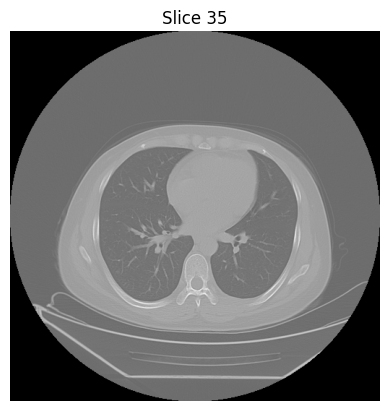

In [8]:
def visualize_slice(volume, slice_index):
    """
    Visualize a single slice from the 3D volume.
    """
    plt.imshow(volume[slice_index], cmap='gray')
    plt.title(f"Slice {slice_index}")
    plt.axis('off')
    plt.show()

# Visualize the middle slice
middle_slice = volume.shape[0] // 2
visualize_slice(volume, middle_slice)

### Load Data with annotations


In [12]:


# Define the path to the annotations file
annotations_csv = os.path.join(dicom_dir, "all_anno_3D.csv")

# Load annotations
annotations = pd.read_csv(annotations_csv)
print("Annotations loaded successfully.")
print(annotations.head())  # Display the first few rows of the annotations

Annotations loaded successfully.
   index         image  x_min  x_max  y_min  y_max  z_min  z_max  x_center  \
0      1   0001_41.bmp    134    139    311    316     41     41       136   
1      2  0002_130.bmp    144    149    321    327    130    130       147   
2      2  0002_131.bmp    143    149    312    327    131    131       147   
3      3   0003_52.bmp    170    181    234    246     52     52       175   
4      3   0003_53.bmp    169    180    235    246     53     53       174   

   y_center  z_center  diameter   label  
0       312        41         6  nodule  
1       325       130         4  nodule  
2       325       131         8  nodule  
3       238        52        12  nodule  
4       240        53        10  nodule  


In [16]:
print(annotations.columns)

Index(['index', 'image', 'x_min', 'x_max', 'y_min', 'y_max', 'z_min', 'z_max',
       'x_center', 'y_center', 'z_center', 'diameter', 'label'],
      dtype='object')


In [22]:
def visualize_slice_with_annotations(volume, slice_index, annotations, patient_id):
    """
    Visualize a single slice with annotations.
    """
    print(f"Visualizing slice {slice_index} for patient {patient_id}...")
    
    # Display the slice
    plt.imshow(volume[slice_index], cmap='gray')
    
    # Filter annotations for the current patient and slice
    patient_annotations = annotations[annotations['image'] == int(patient_id)]
    print(f"Annotations for patient {patient_id}:")
    print(patient_annotations)
    
    # Allow a small tolerance when comparing z_center to slice_index
    tolerance = 1
    slice_annotations = patient_annotations[
        (patient_annotations['z_center'].round() >= slice_index - tolerance) &
        (patient_annotations['z_center'].round() <= slice_index + tolerance)
    ]
    print(f"Annotations for slice {slice_index} (with tolerance ±{tolerance}):")
    print(slice_annotations)
    
    # Plot annotations (e.g., bounding boxes)
    for _, row in slice_annotations.iterrows():
        x_center, y_center, diameter = row['x_center'], row['y_center'], row['diameter']
        print(f"Plotting nodule at ({x_center}, {y_center}) with diameter {diameter}.")
        
        # Mark nodule center
        plt.scatter(x_center, y_center, color='red', s=10, label='Nodule Center')
        
        # Draw bounding circle
        circle = plt.Circle((x_center, y_center), diameter / 2, color='red', fill=False, label='Nodule Boundary')
        plt.gca().add_patch(circle)
    
    plt.title(f"Patient {patient_id}, Slice {slice_index}")
    plt.axis('off')
    plt.legend()
    plt.show()

Volume shape for patient 0001: (70, 512, 512)
Visualizing slice 35...
Annotations loaded successfully.
Visualizing slice 35 for patient 0001...
Annotations for patient 0001:
Empty DataFrame
Columns: [index, image, x_min, x_max, y_min, y_max, z_min, z_max, x_center, y_center, z_center, diameter, label]
Index: []
Annotations for slice 35 (with tolerance ±1):
Empty DataFrame
Columns: [index, image, x_min, x_max, y_min, y_max, z_min, z_max, x_center, y_center, z_center, diameter, label]
Index: []


C:\Users\HP\AppData\Local\Temp\ipykernel_22908\1707553618.py:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


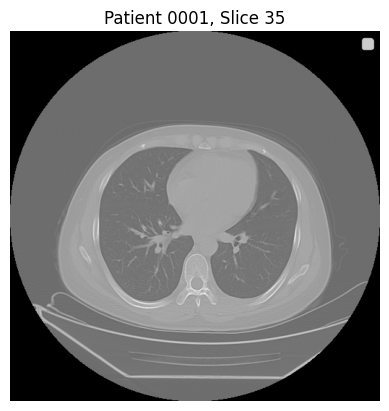

In [23]:
# Define the path to the DICOM folder
dataset_dir = "C:/Dataset"  # Replace with the path to your Dataset folder
dicom_dir = os.path.join(dataset_dir, "DICOM")

# Load DICOM files for a specific patient
patient_id = "0001"  # Replace with the patient folder name
patient_folder = os.path.join(dicom_dir, patient_id)

if os.path.exists(patient_folder):
    # Load DICOM files
    volume, slices = load_dicom_series(patient_folder)
    if volume is not None:
        print(f"Volume shape for patient {patient_id}: {volume.shape}")
        
        # Define the slice index (e.g., middle slice)
        slice_index = volume.shape[0] // 2
        print(f"Visualizing slice {slice_index}...")
        
        # Load annotations
        annotations_csv = os.path.join(dicom_dir, "all_anno_3D.csv")
        annotations = pd.read_csv(annotations_csv)
        print("Annotations loaded successfully.")
        
        # Visualize the slice with annotations
        visualize_slice_with_annotations(volume, slice_index, annotations, patient_id)
    else:
        print("Failed to load DICOM files.")
else:
    print(f"Error: The folder '{patient_folder}' does not exist.")

In [20]:


def segment_lungs(image):
    """
    Segmente les poumons en supprimant les artefacts inutiles et en détectant les plus grandes régions.
    """
    # Normalisation de l'image
    image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    
    # Appliquer un filtre médian pour réduire le bruit
    median_blurred = cv2.medianBlur(image, 5)
    
    # Appliquer un flou gaussien léger pour lisser l'image après réduction du bruit
    blurred = cv2.GaussianBlur(median_blurred, (5, 5), 0)

    # Appliquer un seuillage Otsu pour séparer les poumons
    _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Trouver les contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Garder uniquement les 2 plus grandes régions (les poumons)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:2]

    # Créer un masque vide
    mask = np.zeros_like(image)

    # Remplir les contours détectés
    cv2.drawContours(mask, contours, -1, 255, thickness=cv2.FILLED)

    # Appliquer le masque à l'image d'origine
    segmented = cv2.bitwise_and(image, image, mask=mask)

    return segmented

# Charger une image DICOM (exemple)
def load_dicom_image(filepath):
    dicom = pydicom.dcmread(filepath)
    return dicom.pixel_array

# Affichage des résultats
def visualize_lung_segmentation(image):
    segmented_lungs = segment_lungs(image)

    plt.figure(figsize=(10, 5))

    # Image originale
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title("Image Originale")
    plt.axis('off')

    # Image segmentée (poumons uniquement)
    plt.subplot(1, 2, 2)
    plt.imshow(segmented_lungs, cmap='gray')
    plt.title("Poumons Segmentés")
    plt.axis('off')

    plt.show()



### Visualisation

In [24]:
import pandas as pd

# Charger le fichier CSV
annotations = pd.read_csv("C:/Dataset/DICOM/all_anno_3D.csv")

# Afficher les premières lignes pour vérifier
print(annotations.head())

   index         image  x_min  x_max  y_min  y_max  z_min  z_max  x_center  \
0      1   0001_41.bmp    134    139    311    316     41     41       136   
1      2  0002_130.bmp    144    149    321    327    130    130       147   
2      2  0002_131.bmp    143    149    312    327    131    131       147   
3      3   0003_52.bmp    170    181    234    246     52     52       175   
4      3   0003_53.bmp    169    180    235    246     53     53       174   

   y_center  z_center  diameter   label  
0       312        41         6  nodule  
1       325       130         4  nodule  
2       325       131         8  nodule  
3       238        52        12  nodule  
4       240        53        10  nodule  


#### 2D

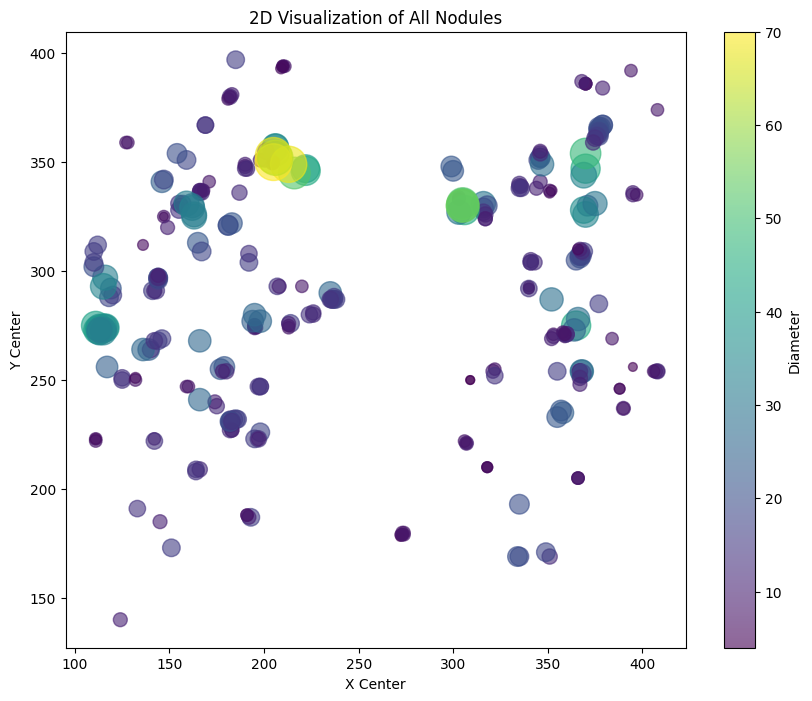

In [25]:


def visualize_all_nodules_2d(annotations):
    """
    Visualize all nodules in a 2D scatter plot.
    """
    plt.figure(figsize=(10, 8))

    # Extract positions and diameters
    x_centers = annotations['x_center']
    y_centers = annotations['y_center']
    diameters = annotations['diameter']

    # Create a scatter plot
    plt.scatter(x_centers, y_centers, s=diameters * 10, c=diameters, cmap='viridis', alpha=0.6)

    # Add labels and title
    plt.title("2D Visualization of All Nodules")
    plt.xlabel("X Center")
    plt.ylabel("Y Center")
    plt.colorbar(label="Diameter")

    # Show the plot
    plt.show()

# Call the function
visualize_all_nodules_2d(annotations)

#### 3D

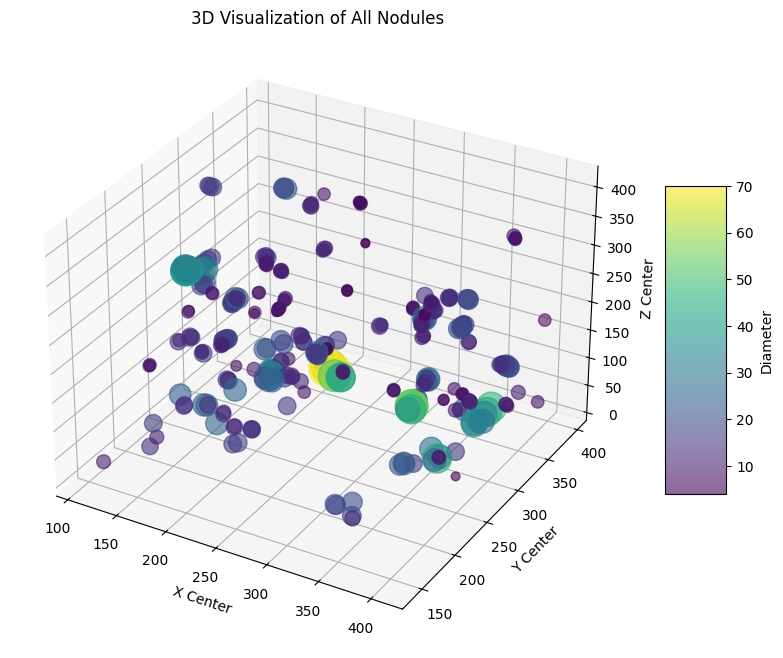

In [26]:
from mpl_toolkits.mplot3d import Axes3D

def visualize_all_nodules_3d(annotations):
    """
    Visualize all nodules in a 3D scatter plot.
    """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Extract positions and diameters
    x_centers = annotations['x_center']
    y_centers = annotations['y_center']
    z_centers = annotations['z_center']
    diameters = annotations['diameter']

    # Create a 3D scatter plot
    scatter = ax.scatter(x_centers, y_centers, z_centers, s=diameters * 10, c=diameters, cmap='viridis', alpha=0.6)

    # Add labels and title
    ax.set_xlabel("X Center")
    ax.set_ylabel("Y Center")
    ax.set_zlabel("Z Center")
    ax.set_title("3D Visualization of All Nodules")

    # Add a color bar
    cbar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=5)
    cbar.set_label("Diameter")

    # Show the plot
    plt.show()

# Call the function
visualize_all_nodules_3d(annotations)

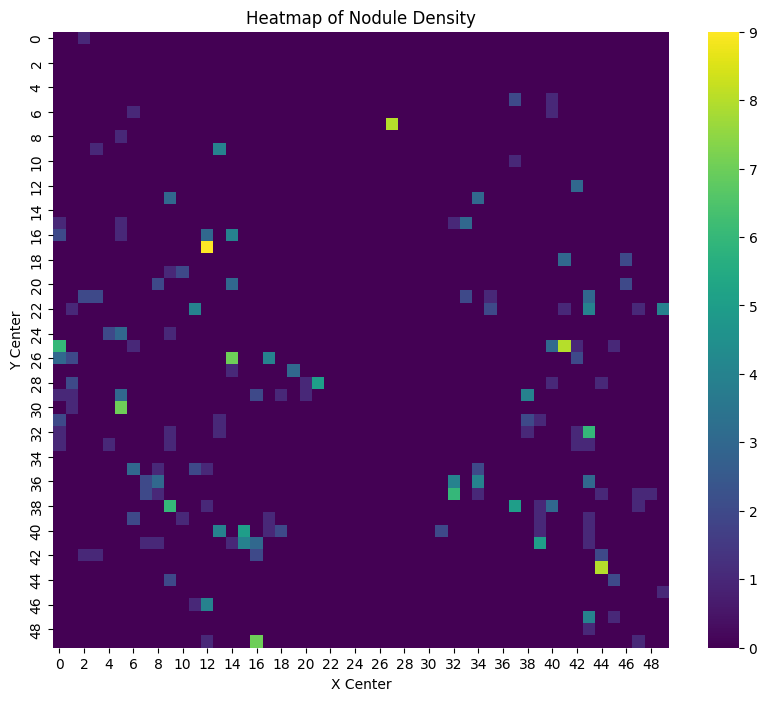

In [27]:


def fancy_heatmap(annotations):
    """
    Create a heatmap of nodule density using Seaborn.
    """
    # Create a 2D histogram of nodule positions
    heatmap, xedges, yedges = np.histogram2d(
        annotations['x_center'],
        annotations['y_center'],
        bins=(50, 50)  # Adjust the number of bins as needed
    )

    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(heatmap.T, cmap='viridis', cbar=True, square=True)
    plt.title("Heatmap of Nodule Density")
    plt.xlabel("X Center")
    plt.ylabel("Y Center")
    plt.show()

# Call the function
fancy_heatmap(annotations)

In [29]:
import plotly.express as px

# Create the histogram
fig = px.histogram(
    annotations,  # Use your DataFrame
    x='diameter',  # Column for the x-axis (diameter)
    nbins=30,  # Number of bins
    title='Nodule Size Distribution (Histogram)',
    labels={'diameter': 'Diameter (mm)'},  # Axis labels
    color_discrete_sequence=['blue']  # Color of the bars
)

# Update layout for better visualization
fig.update_layout(
    xaxis_title='Diameter (mm)',
    yaxis_title='Frequency',
    bargap=0.1  # Gap between bars
)

# Show the plot
fig.show()

In [30]:
import plotly.express as px

# Create the box plot
fig = px.box(
    annotations,  # Use your DataFrame
    y='diameter',  # Column for the y-axis (diameter)
    title='Nodule Size Distribution (Box Plot)',
    labels={'diameter': 'Diameter (mm)'},  # Axis labels
    color_discrete_sequence=['green']  # Color of the box plot
)

# Update layout for better visualization
fig.update_layout(
    yaxis_title='Diameter (mm)',
    showlegend=False  # Hide legend
)

# Show the plot
fig.show()

In [10]:
#

## Data Cleaning

### Handle Missing Values

In [33]:
# Check for missing values
print(annotations.isnull().sum())

# Fill missing values with the median
annotations['diameter'].fillna(annotations['diameter'].median(), inplace=True)

index       0
image       0
x_min       0
x_max       0
y_min       0
y_max       0
z_min       0
z_max       0
x_center    0
y_center    0
z_center    0
diameter    0
label       0
dtype: int64


C:\Users\HP\AppData\Local\Temp\ipykernel_22908\3481615440.py:5: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





### Remove Duplicates

In [34]:
annotations.drop_duplicates(inplace=True)

#### Data Processing


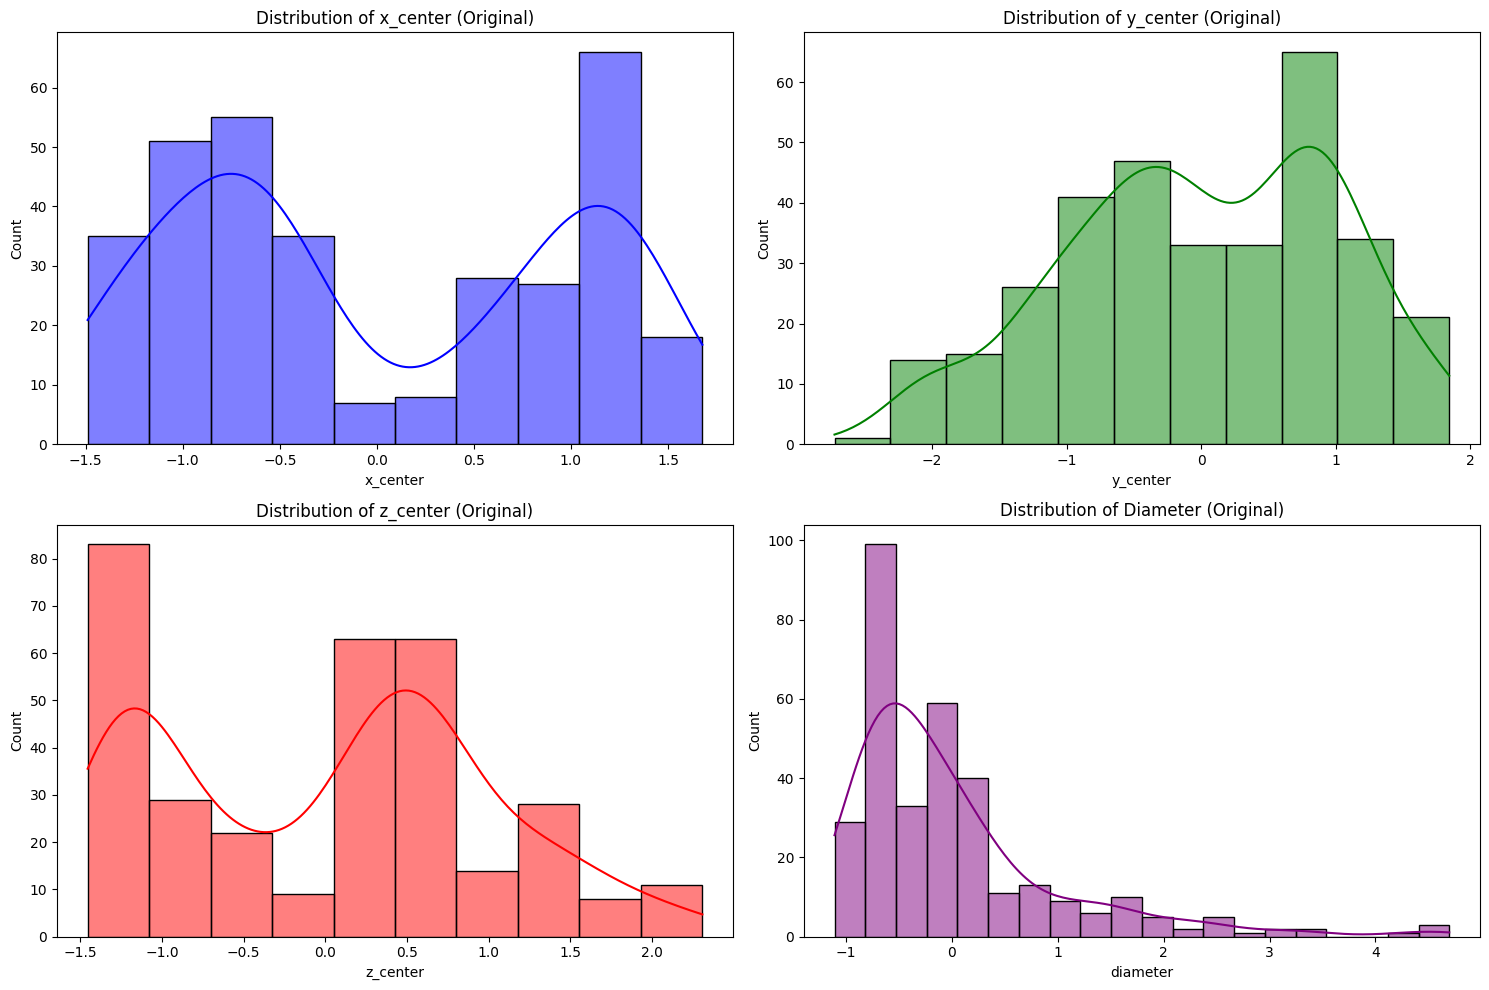

In [ ]:
# Step 1: Explore the Data (Visualize Original Distributions)
plt.figure(figsize=(15, 10))

# Plot the distribution of numerical features
plt.subplot(2, 2, 1)
sns.histplot(annotations['x_center'], kde=True, color='blue')
plt.title('Distribution of x_center (Original)')

plt.subplot(2, 2, 2)
sns.histplot(annotations['y_center'], kde=True, color='green')
plt.title('Distribution of y_center (Original)')

plt.subplot(2, 2, 3)
sns.histplot(annotations['z_center'], kde=True, color='red')
plt.title('Distribution of z_center (Original)')

plt.subplot(2, 2, 4)
sns.histplot(annotations['diameter'], kde=True, color='purple')
plt.title('Distribution of Diameter (Original)')

plt.tight_layout()
plt.show()

### Normalization

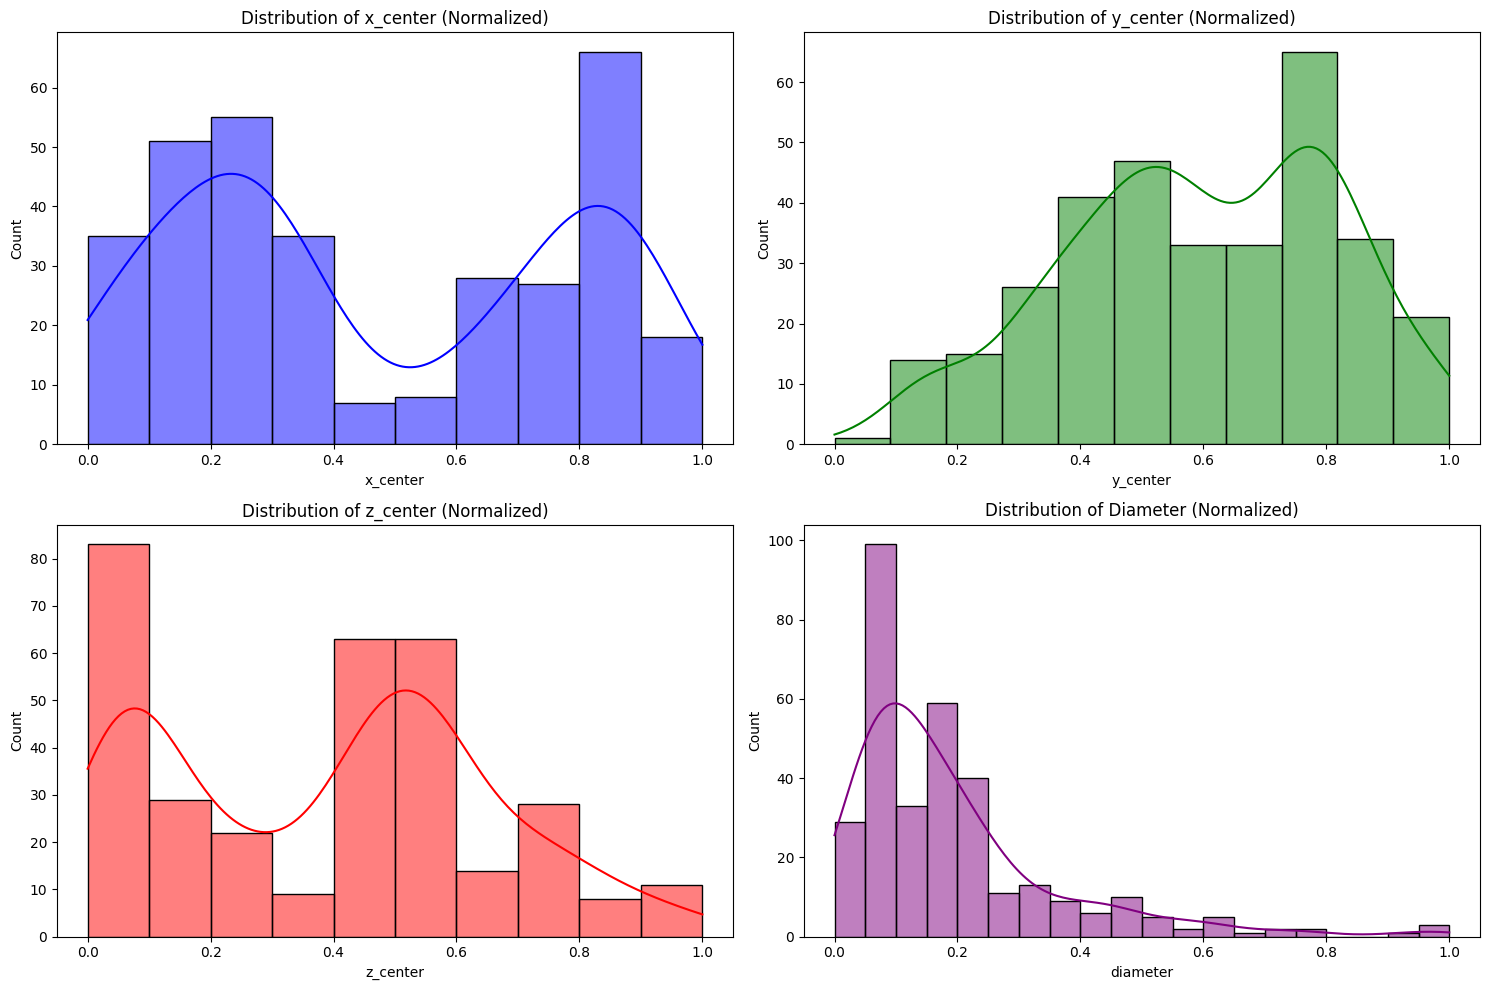

In [ ]:
# Step 2: Normalize the Data
# Select the columns to normalize
columns_to_scale = ['x_center', 'y_center', 'z_center', 'diameter']

# Initialize the MinMaxScaler
minmax_scaler = MinMaxScaler()

# Apply normalization
annotations_normalized = annotations.copy()
annotations_normalized[columns_to_scale] = minmax_scaler.fit_transform(annotations[columns_to_scale])

# Visualize the normalized distributions
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.histplot(annotations_normalized['x_center'], kde=True, color='blue')
plt.title('Distribution of x_center (Normalized)')

plt.subplot(2, 2, 2)
sns.histplot(annotations_normalized['y_center'], kde=True, color='green')
plt.title('Distribution of y_center (Normalized)')

plt.subplot(2, 2, 3)
sns.histplot(annotations_normalized['z_center'], kde=True, color='red')
plt.title('Distribution of z_center (Normalized)')

plt.subplot(2, 2, 4)
sns.histplot(annotations_normalized['diameter'], kde=True, color='purple')
plt.title('Distribution of Diameter (Normalized)')

plt.tight_layout()
plt.show()

### Standardization

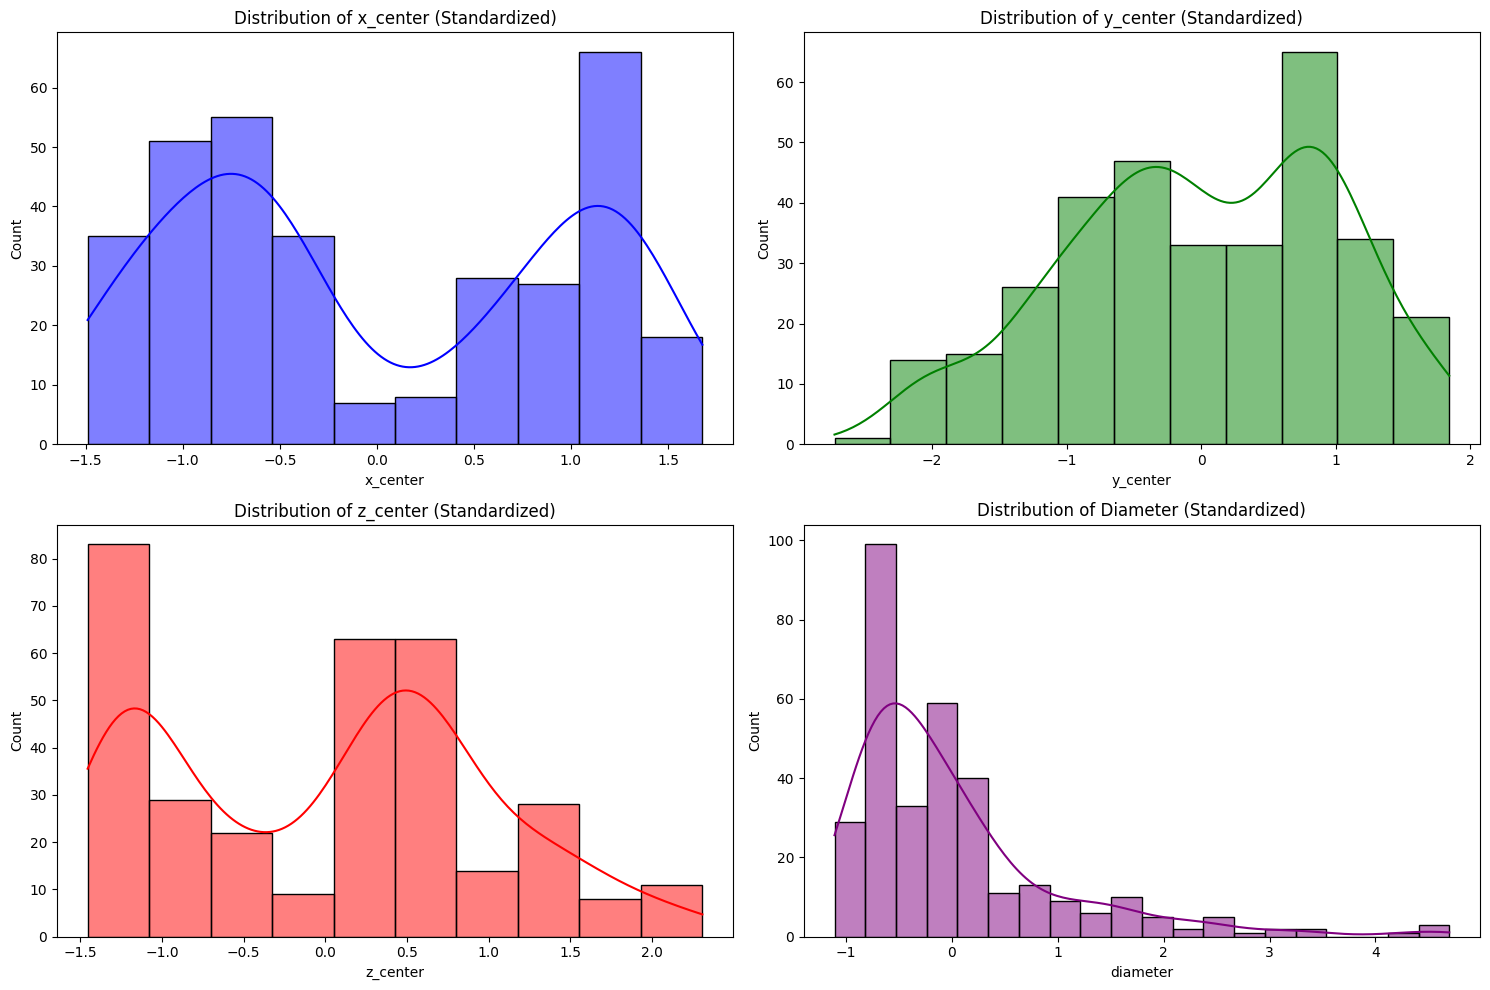

In [42]:
# Step 3: Standardize the Data
# Initialize the StandardScaler
standard_scaler = StandardScaler()

# Apply standardization
annotations_standardized = annotations.copy()
annotations_standardized[columns_to_scale] = standard_scaler.fit_transform(annotations[columns_to_scale])

# Visualize the standardized distributions
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.histplot(annotations_standardized['x_center'], kde=True, color='blue')
plt.title('Distribution of x_center (Standardized)')

plt.subplot(2, 2, 2)
sns.histplot(annotations_standardized['y_center'], kde=True, color='green')
plt.title('Distribution of y_center (Standardized)')

plt.subplot(2, 2, 3)
sns.histplot(annotations_standardized['z_center'], kde=True, color='red')
plt.title('Distribution of z_center (Standardized)')

plt.subplot(2, 2, 4)
sns.histplot(annotations_standardized['diameter'], kde=True, color='purple')
plt.title('Distribution of Diameter (Standardized)')

plt.tight_layout()
plt.show()

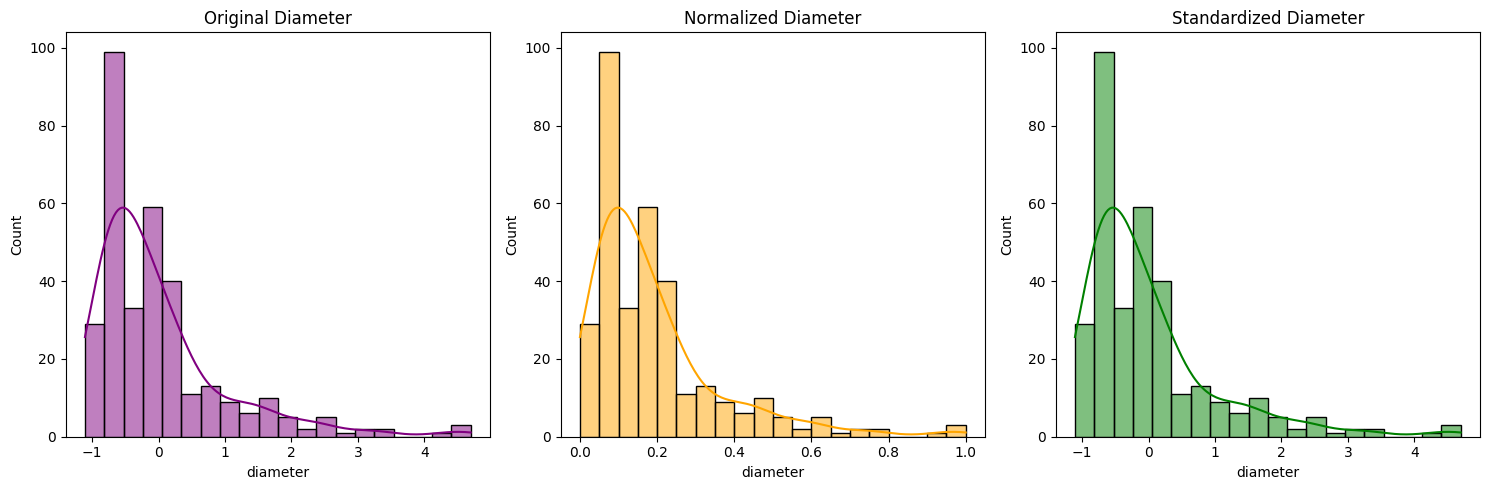

In [43]:
# Step 4: Compare the Results
# Compare original, normalized, and standardized data for one feature (e.g., diameter)
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(annotations['diameter'], kde=True, color='purple')
plt.title('Original Diameter')

plt.subplot(1, 3, 2)
sns.histplot(annotations_normalized['diameter'], kde=True, color='orange')
plt.title('Normalized Diameter')

plt.subplot(1, 3, 3)
sns.histplot(annotations_standardized['diameter'], kde=True, color='green')
plt.title('Standardized Diameter')

plt.tight_layout()
plt.show()